<a href="https://colab.research.google.com/github/AlexandreAdam/torch_score_models/blob/dev/notebooks/score_based_modelling_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchquad --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 4.9 MB/s eta 0:00:00


In [2]:
%matplotlib inline

import torch
import numpy
import matplotlib.pyplot as plt
import torch.distributions as tfd
import numpy as np
from tqdm import tqdm
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#@title Utility functions, make sure to run this cell
from scipy.interpolate import interpn
from matplotlib.colors import Normalize
import matplotlib.pylab as pylab
import matplotlib.cm as cm
plt.style.use("dark_background")
params = {
    'legend.fontsize': 20,
    'figure.figsize': (5, 5),
    'axes.labelsize': 20,
    'axes.titlesize': 25,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'figure.titlesize': 25,
    'xtick.major.size': 8,
    'xtick.minor.size': 4,
    'xtick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1,
    'ytick.minor.width': 1,
    'font.size': 20 # for annotate
}
pylab.rcParams.update(params)


def density_scatter(points, fig=None, ax=None, sort=True, bins=20, cmap="magma", norm=None, ticks=None, colorbar=False, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    x = points[:, 0]
    y = points[:, 1]
    if ax is None:
        fig, ax = plt.subplots()
    data, x_edges, y_edges = np.histogram2d(x, y, bins=bins, density=True)
    x_bins = 0.5 * (x_edges[1:] + x_edges[:-1])
    y_bins = 0.5 * (y_edges[1:] + y_edges[:-1])
    z = interpn((x_bins, y_bins), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    if norm is None:
        norm = Normalize(vmin=z.min(), vmax=z.max())
    ax.scatter(x, y, c=z, cmap=cmap, norm=norm, **kwargs)
    if fig is not None:
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        box = ax.get_position()
        cax = plt.axes([box.x0*1.01 + box.width * 1.05, box.y0, 0.02, box.height])
        fig.colorbar(sm, cax=cax, ticks=ticks)
        cax.set_ylabel('Density')
    return ax

def vector_field(gradient_function, xmin, xmax, ymin, ymax, n=20, dx=0.05, scale=1.5e3, width=0.007, fig=None, ax=None):
    x = np.linspace(xmin, xmax, n)
    y = np.linspace(ymin, ymax, n)
    points = np.stack(np.meshgrid(x, y), axis=-1).reshape((-1, 2))
    g = gradient_function(torch.tensor(points).to(DEVICE).float()).detach().numpy().reshape([n, n, 2])
    colors = np.sqrt(g[..., 0]**2 + g[..., 1]**2).ravel()
    if ax is None:
        fig, ax = plt.subplots()
    norm = Normalize()
    colormap = cm.magma
    ax.quiver(x, y, g[..., 0], g[..., 1], color=colormap(norm(colors)), scale=scale, width=width)
    if fig is not None:
        sm = cm.ScalarMappable(norm=norm, cmap=colormap)
        sm.set_array([])
        box = ax.get_position()
        cax = plt.axes([box.x0*1.01 + box.width * 1.05, box.y0, 0.02, box.height])
        fig.colorbar(sm, cax=cax)
        cax.set_ylabel(r"$|| \nabla_{\mathbf{x}} \log p(\mathbf{x})||$")
    return ax

def density_contours(density_function, xmin, xmax, ymin, ymax, confidence_intervals, dx=0.01, dy=0.01, fig=None, ax=None):
    x = np.arange(xmin, xmax, dx)
    y = np.arange(ymin, ymax, dy)
    n = x.size
    m = y.size
    points = np.stack(np.meshgrid(x, y), axis=-1).reshape((-1, 2))
    p = density_function(torch.tensor(points).to(DEVICE)).detach().numpy().reshape([m, n])
    if ax is None:
        fig, ax = plt.subplots()

    cumul = np.sort(p.ravel() * dx * dy)[::-1].cumsum()
    ps = []
    len_ci = len(confidence_intervals)
    for ci in confidence_intervals:
        p_at_ci = np.sort(p.ravel())[::-1][np.argmin((cumul - ci)**2)]
        ps.append(p_at_ci)
    cs = ax.contour(x, y, p, levels=ps[::-1], colors=[plt.cm.cool(i/(len_ci-1)) for i in range(len_ci)], linewidths=2, linestyles="--")

    def fmt(x):
        ci = cumul[np.argmin((x - np.sort(p.ravel())[::-1])**2)]
        s = f"{ci*100:.1f}"
        if s.endswith("0"):
            s = f"{ci*100:.0f}"
        return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"
    ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=10)

    return ax


# What is the score?

In statistics, the score is a measure of how steeply a probability distribution rises or falls at a particular point. It is calculated as the gradient of the logarithm of the probability density function (PDF) at that point.
$$
  \mathbf{s}(\mathbf{x}) \equiv \nabla_{\mathbf{x}}\log p(\mathbf{x})
$$

The score is a valuable concept in statistics because it has two important properties. Firstly, it can be approximated very accurately by any universal approximator, i.e. a function that can approximate other functions well. Secondly, the score is used as the foundation of many efficient algorithms for sampling from probability distributions, such as the Metropolis-adjusted Langevin dynamics, Hamiltonian Monte Carlo, and diffusion algorithms.


Log probability of (0, 0): -97.23269653320312


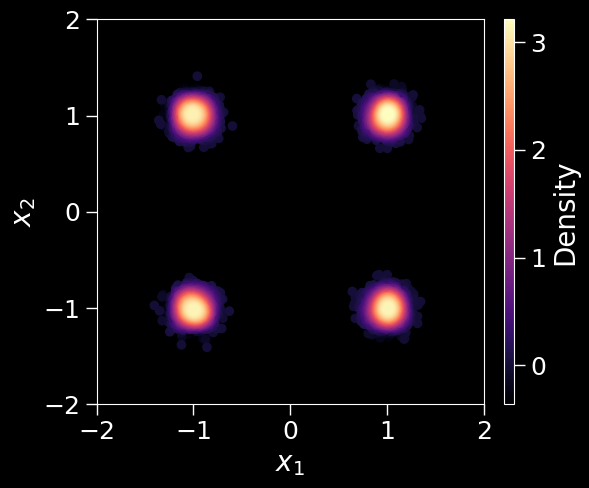

In [4]:
# We first define a tow distribution we wish to learn
def four_gaussians(size=1, mode_width=0.1):
    coords = torch.tensor([
        [size, size],
        [size, -size],
        [-size, size],
        [-size, -size]
    ]).to(DEVICE, torch.float32)
    mixture = tfd.Categorical(probs=torch.ones(4).to(DEVICE), validate_args=False)
    component = tfd.Independent(tfd.Normal(loc=coords, scale=mode_width, validate_args=False), 1)
    return tfd.MixtureSameFamily(mixture, component, validate_args=False)

dist = four_gaussians()

# We have access to the log_prob using dist.log_prob
x = torch.tensor([0, 0])
logp = dist.log_prob(x)
print(f"Log probability of (0, 0): {logp}")

# We can sample from the distribution
x = dist.sample([10000])
ax = density_scatter(x.cpu().numpy())
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");

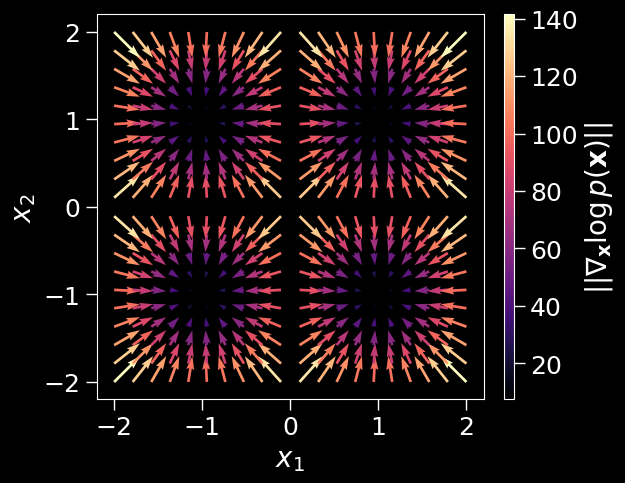

In [5]:
# We can get access to the score using automatic differentiation
# Since grad expect a scalar, we use grad and vmap together for a batched gradient
from torch.func import grad
from torch import vmap # parallelize a function over its batch dimension
def true_score(x):
    return vmap(grad(dist.log_prob))(x)

ax = vector_field(true_score, xmin=-2, xmax=2, ymin=-2, ymax=2, n=20, dx=0.05)
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");

# Langevin dynamics

The core idea of sampling using Langevin dynamics is to move a walker in the direction of the score, and perturbing this walk by some random noise
$$
  \mathbf{x}_{t+1} = \mathbf{x}_t + \frac{\epsilon}{2} \nabla_{\mathbf{x}_t}\log p(\mathbf{x}_t) + \sqrt{\epsilon}\mathbf{z}
$$
where $\mathbf{z} \sim \mathcal{N}(0, 1)$ is the brownian motion added to the walk and $\epsilon$ is the step size of the walk. In the following cells, we explore how the gradient contributes to sampling more efficiently the density.

## Some checks

In [6]:
from torchquad import Simpson
# First, make sure the distribution is normalized. Here I show a trick to integrate the density function over the domain that is useful to know
Z = Simpson().integrate(
    fn=lambda x: torch.exp(dist.log_prob(x)),
    dim=2,
    N=100000,
    integration_domain=[[-5, 5], [-5, 5]]
    )
print(f"The evidence should be equal to 1 (or very close to 1): Z = {Z}")

The evidence should be equal to 1 (or very close to 1): Z = 0.9999915957450867


/usr/local/lib/python3.10/dist-packages/torchquad/integration/simpson.py:77: UserWarning: N per dimension cannot be even due to necessary subdivisions. N per dim will now be changed to the next lower integer, i.e. 316 -> 315.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


## Brownian motion

<ipython-input-7-91d6b413e03e>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', iterations)


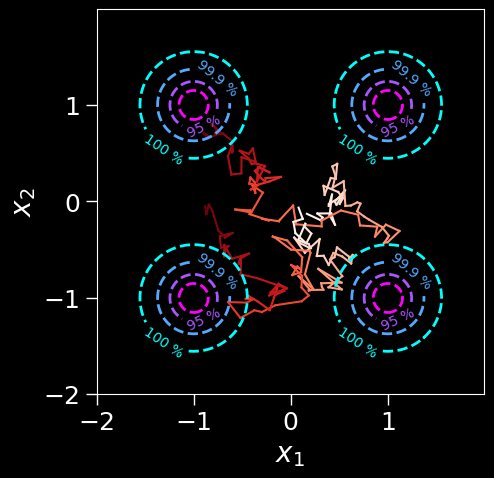

In [7]:
# First, let us now consider only random walk
def random_walk_step(x, epsilon):
    z = torch.randn_like(x)
    return x + np.sqrt(epsilon) * z

iterations = 100
epsilon = 0.05
W = 2 # number of walkers
sigma_init = 0.01
x = torch.randn([W, 2]) * sigma_init # some initial conditions
epsilon = 0.01
random_walk = []
for _ in range(iterations):
    x = random_walk_step(x, epsilon)
    random_walk.append(x.cpu().numpy())
random_walk = np.stack(random_walk, axis=1)

# Plot the random walk with a color gradient showing evolution
fig, ax = plt.subplots()
cmap = plt.cm.get_cmap('Reds', iterations)
for w in range(W):
    for i in range(iterations-1):
        ax.plot(random_walk[w, i:i+2, 0], random_walk[w, i:i+2, 1], color=cmap(i))
# For reference, we plot the density contours on top of the random walk
def density(x):
    return torch.exp(dist.log_prob(x))
ax = density_contours(density, xmin=-2, xmax=2, ymin=-2, ymax=2, confidence_intervals=[0.68, 0.95, 0.999, 0.9999999], ax=ax)

ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");

## Langevin dynamics

<ipython-input-8-74adc4b5f171>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', iterations)


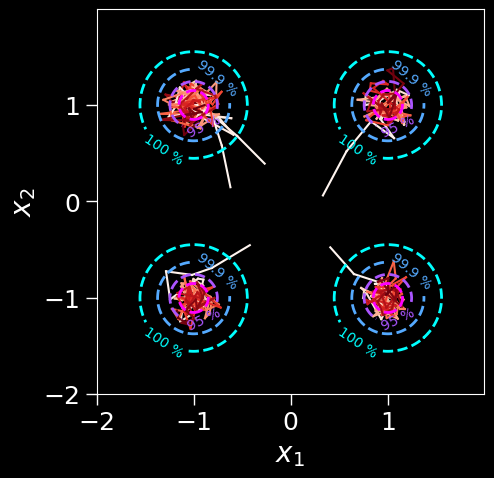

In [8]:
# Let's do the same exercise, but with the score
# First, let us now consider only random walk
def langevin_step(x, epsilon): # assumes epsilon is a float
    z = torch.randn_like(x)
    return x + 0.5 * epsilon * true_score(x) + np.sqrt(epsilon) * z

iterations = 100
epsilon = 0.05
sigma_init = 0.01
W = 5
x = torch.randn([W, 2]) * sigma_init # some initial conditions
epsilon = 0.01
langevin_walk = []
for _ in range(iterations):
    x = langevin_step(x, epsilon)
    langevin_walk.append(x.cpu().numpy())
langevin_walk = np.stack(langevin_walk, axis=1)

# Plot the random walk with a color gradient showing evolution
fig, ax = plt.subplots()
cmap = plt.cm.get_cmap('Reds', iterations)
for w in range(W):
    for i in range(iterations-1):
        ax.plot(langevin_walk[w, i:i+2, 0], langevin_walk[w, i:i+2, 1], color=cmap(i))
# For reference, we plot the density contours on top of the random walk
def density(x):
    return torch.exp(dist.log_prob(x))
ax = density_contours(density, xmin=-2, xmax=2, ymin=-2, ymax=2, confidence_intervals=[0.68, 0.95, 0.999, 0.9999999], ax=ax)

ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");

# Naive score matching

We now consider the simplest and most naive way to learn the score, assuming we have access to the true density. We will see in the next section how to improve it and deal with situations where we don't have access to the score.

We consider the simple regression task of learning the score directly with a neural network $\mathbf{x}_\theta(\mathbf{x}): \mathbb{R}^n \to \mathbb{R}^n$
$$
  \mathcal{L}_\theta = \mathbb{E}_{\mathbf{x} \sim p(\mathbf{x}} \big[\lVert \mathbf{s}_\theta(\mathbf{x}) - \nabla_{\mathbf{x}} \log p(\mathbf{x}) \rVert^2 \big]
$$

The ideas of score matching were first developed by
- [Aapo Hyvarïnen (2005)](https://www.jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf)
- [Pascal Vincent (2011)](https://www.iro.umontreal.ca/~vincentp/Publications/DenoisingScoreMatching_NeuralComp2011.pdf)

A useful resource is [Yang Song's blog post](https://yang-song.net/blog/2021/score/)


100%|██████████| 3000/3000 [00:15<00:00, 197.69it/s]


Text(0.5, 0, 'Iteration')

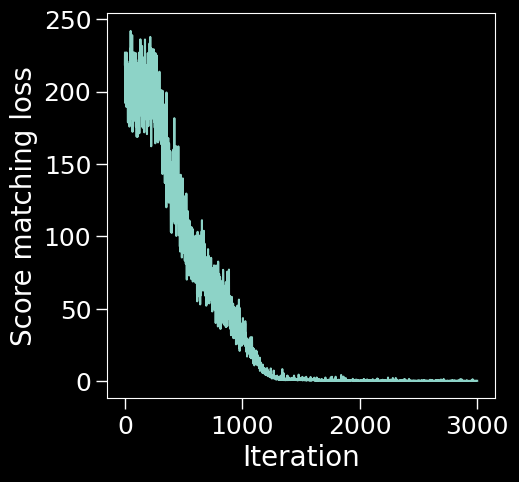

In [9]:
# Define a simple R^n to R^n neural network architecture
from torch import nn
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ELU(),
    nn.Linear(10, 10),
    nn.ELU(),
    nn.Linear(10, 2)
)

# Then train this architecture with score matching
iterations = 3000
batch_size = 128
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for _ in tqdm(range(iterations)):
    optimizer.zero_grad()
    x = dist.sample([batch_size])
    loss = torch.sum((model(x) - true_score(x))**2) / batch_size
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.ylabel("Score matching loss")
plt.xlabel("Iteration")

Text(0.5, 0, '$x_1$')

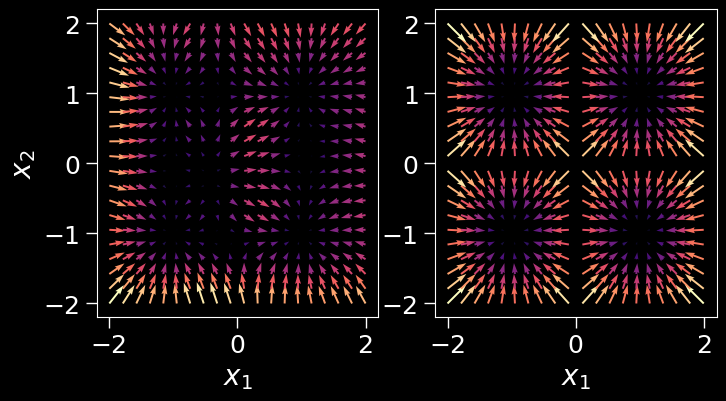

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1 = vector_field(model, xmin=-2, xmax=2, ymin=-2, ymax=2, n=20, dx=0.05, ax=ax1)
ax2 = vector_field(true_score, xmin=-2, xmax=2, ymin=-2, ymax=2, n=20, dx=0.05, ax=ax2)

ax1.set_ylabel(r"$x_2$")
ax1.set_xlabel(r"$x_1$")
ax2.set_xlabel(r"$x_1$")

# Introducing temperatures

Even though we had access to perfect information, we still couldn't learn the score because we were not exploring the regions of low density! The solution, both to sampling in high dimension and training the score model, is to introduce a temperature schedule to "anneal", or "smooth" the probability density function. The simplest way to anneal a distribution is to "add noise", so to speak. The rule goes as follows:

Let $\mathbf{x}_0 \sim p(\mathbf{x})$, a sample from our distribution of interest, and let $\mathbf{z}_t \sim \mathcal{N}(0, \sigma^2_t\mathbb{1}_n)$, a vector of white noise with a certain "temperature" $\sigma^2_t$

Adding noise to $\mathbf{x}_0$
$$
  \mathbf{x}_t = \mathbf{x}_0 + \mathbf{z}\, ,
$$
is equivalent to convolving the respective densities of $\mathbf{x}_0$ and $\mathbf{z}_t$
$$
  p_t(\mathbf{x}_t) = p(\mathbf{x}_0) \circledast \mathcal{N}(0, \sigma^2_t\mathbb{1})
$$

You can look in [this wikipedia page](https://colab.research.google.com/drive/1HD1xN60aJP6PsrGaGRR6VKUPMa2TOuP7#scrollTo=AViUtIKM0toR&line=20&uniqifier=1)
for a list of useful results.

Let us reuse our previous example and add noise to it. Since we considered
a mixture of gaussians with means $\boldsymbol{\mu}_i$ and covariance $\sigma^2\mathbb{1}$, the convolution yields
$$
\begin{align}
    p_t(\mathbf{x}_t) &= \frac{1}{4}\sum_{i=1}^4 \mathcal{N}(\boldsymbol{\mu}_i, \sigma^2 \mathbb{1}_n) \circledast \mathcal{N}(0, \sigma^2_t\mathbb{1}) \\
      &=  \frac{1}{4}\sum_{i=1}^4 \mathcal{N}(\boldsymbol{\mu}_i, (\sigma^2 + \sigma_t^2)\mathbb{1}_n)
\end{align}
$$

In [11]:
# First define a temperature schedule. We use some foresight and use a geometric series
sigma_x0 = 0.1 # the original width of our modes

sigma_min = 1e-2 # minimum temperature
sigma_max = 2 # maximum temperature
def sigma(t):
  return sigma_min * (sigma_max / sigma_min)**t

def log_prob(x, t):
    """
      Define the distribution at the correct temperature, then evalute log_prob
    """
    width = torch.sqrt(sigma_x0**2 + sigma(t)**2)
    return four_gaussians(mode_width=width).log_prob(x)

def density(x, t):
    return torch.exp(log_prob(x, t))

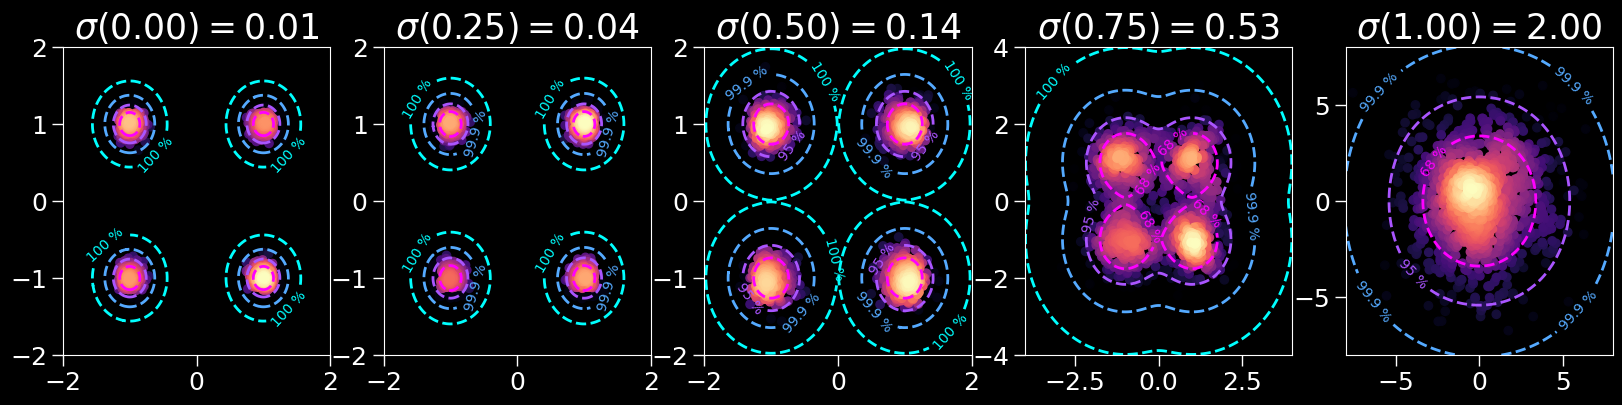

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

ts = [0, 0.25, 0.5, 0.75, 1]
_max = [2, 2, 2, 4, 8]
N = 1000
for i, t in enumerate(ts):
    # add noise to zero temperature samples
    x = dist.sample([N])
    x_t = x + torch.randn_like(x) * sigma(t)
    ax_i = density_scatter(x_t.cpu().numpy(), ax=axs[i], bins=10)
    ax_i = density_contours(lambda x: density(x, torch.tensor(t)), xmin=-_max[i], xmax=_max[i], ymin=-_max[i], ymax=_max[i], confidence_intervals=[0.68, 0.95, 0.999, 0.9999999], ax=ax_i)
    ax_i.set_ylim(-_max[i], _max[i])
    ax_i.set_xlim(-_max[i], _max[i])
    ax_i.set_title(f"$\sigma(%.2f) = %.2f$" % (t, sigma(t)))

# Denoising score matching

We are now in a position to learn the score everywhere, simply by adding noise. We just need to condition the network on the time index $t$, since we actually have to the score of all the distributions implied by our temperature schedule.

The score matching objective is modified in the following way
$$
  \mathcal{L}_\theta = \mathbb{E}_{\mathbf{x} \sim p(\mathbf{x})} \mathbb{E}_{t \sim \mathcal{U}(0, 1)} \mathbb{E}_{\mathcal{z} \sim \mathcal{N}(0, 1)} \big[\lambda(t) \lVert \mathbf{s}_\theta(\mathbf{x} + \sigma_t \mathbf{z}, t) - \nabla_{\mathbf{x}} p_t(\mathbf{x} + \sigma_t \mathbf{z})\rVert^2 \big]
$$
where $\lambda(t)$ is a weighting factor that we choose to be $\lambda(t) \propto \sigma^2(t)$. We also redefine the model so that it is easier to train
$$
  \mathbf{s}_\theta(\mathbf{x}, t) = \frac{\boldsymbol{\epsilon}_\theta(\mathbf{x}, t)}{\sigma(t)}
$$

In [23]:
class Model(nn.Module):
    def __init__(self, scale=16, embed_dim=32, units=100):
        super().__init__()
        self.nn1 = nn.Linear(2+embed_dim, units)
        self.nn2 = nn.Linear(units, units)
        self.nn3 = nn.Linear(units, 2)
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
        self.act = nn.SiLU()

    def forward(self, x, t):
        t_proj = t[:, None] * self.W[None, :] * 2 * np.pi
        temb = torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=1)
        x = torch.cat([x, temb], dim=1)
        x = self.nn1(x)
        x = self.act(x)
        x = self.nn2(x)
        x = self.act(x)
        x = self.nn3(x) / sigma(t).view(-1, 1) # redefinition here is important
        return x

100%|██████████| 15000/15000 [01:48<00:00, 138.85it/s]


Text(0.5, 0, 'Iteration')

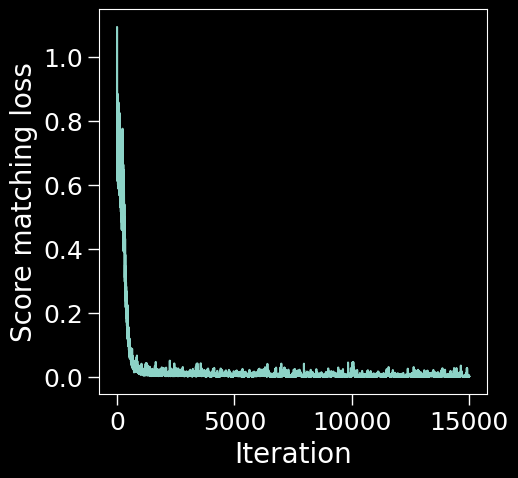

In [30]:
def true_score(x, t):
    return vmap(grad(log_prob))(x, t)

model = Model()
iterations = 15000
batch_size = 256
learning_rate = 4e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for _ in tqdm(range(iterations)):
    optimizer.zero_grad()
    x = dist.sample([batch_size])
    t = torch.rand(batch_size).to(DEVICE)
    z = torch.randn_like(x)
    lambda_t = (sigma(t)**2).view(-1, 1)
    loss = torch.sum(lambda_t * (model(x + sigma(t)[:, None] * z, t) - true_score(x + sigma(t)[:, None] * z, t[:, None]))**2) / batch_size
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.ylabel("Score matching loss")
plt.xlabel("Iteration")

Text(0, 0.5, 'True score')

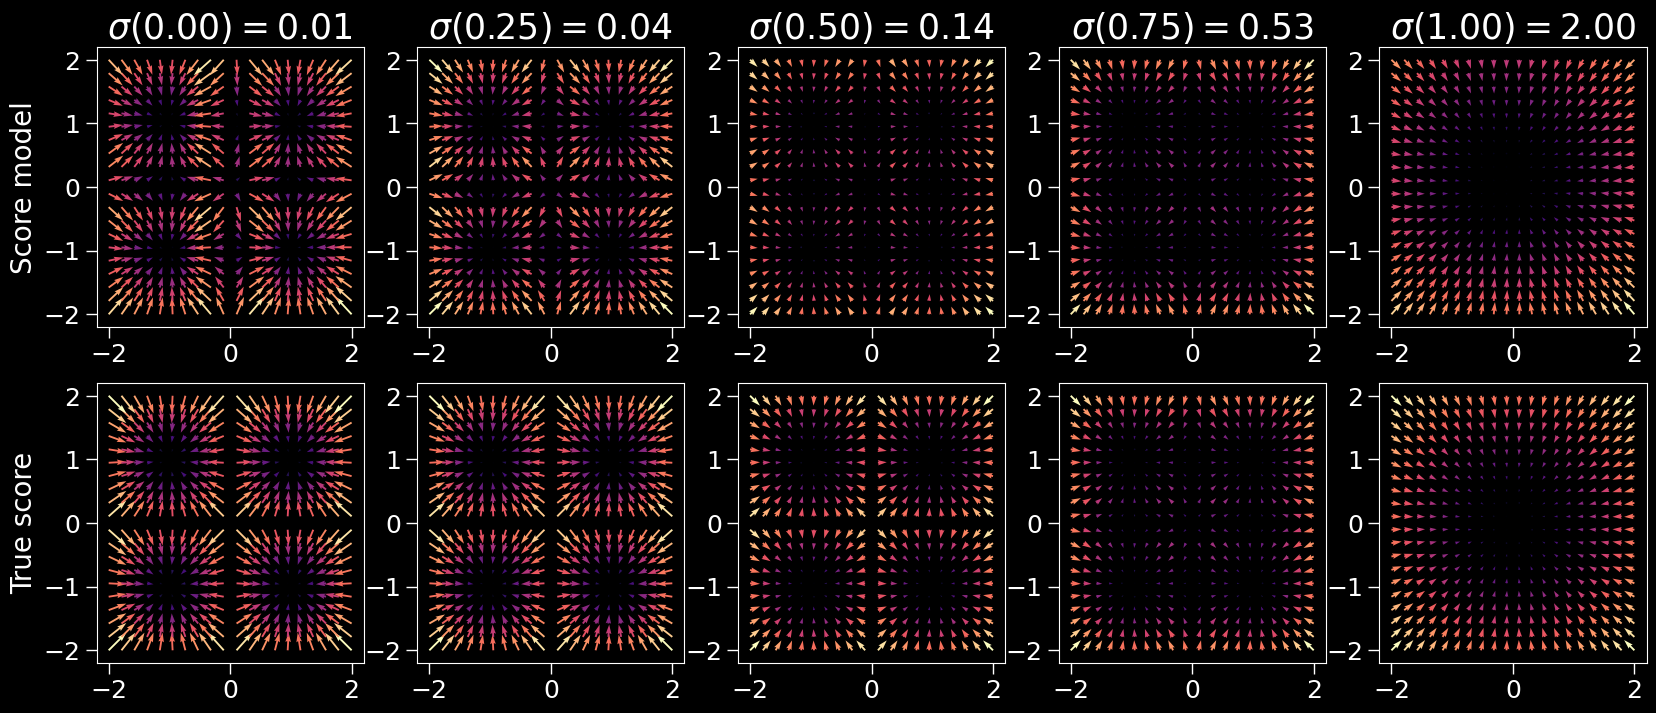

In [31]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))


ts = [0, 0.25, 0.5, 0.75, 1]
scales = [1.5e3, 1.5e3, 9e2, 9e1, 1e1]
for i, t in enumerate(ts):
    ax1 = vector_field(lambda x: model(x, torch.ones(20**2).to(DEVICE)*t), xmin=-2, xmax=2, ymin=-2, ymax=2, n=20, dx=0.05, scale=scales[i], ax=axs[0, i])
    ax2 = vector_field(lambda x: true_score(x, torch.ones(20**2).to(DEVICE)*t), xmin=-2, xmax=2, ymin=-2, ymax=2, n=20, dx=0.05, scale=scales[i], ax=axs[1, i])
    ax1.set_title(f"$\sigma(%.2f) = %.2f$" % (t, sigma(t)))

axs[0, 0].set_ylabel(r"Score model")
axs[1, 0].set_ylabel(r"True score")

# Sampling using a stochastic differential equation

In the previous section, we framed addind noise as a convolution. We can also frame adding noise as a stochastic differential equation. That is, suppose, like before, that $\mathbf{x}_0 \sim p(\mathbf{x}_0)$ is the initial condition. Adding noise $\mathbf{z}_t \sim \mathcal{N}(0, \sigma^2(t) \mathbb{1}_n)$ can done by integrating the following expression
$$
  d\mathbf{x} = g(t) d \mathbf{w}
$$
from 0 to some $t$. $g(t) = \sqrt{\frac{d \sigma^2(t)}{dt}}$ describes how the standard deviation of the noise changes through time. $\mathbf{w}$ is a Brownian motion random variable. In practice,
$$
  d \mathbf{w} \approx \mathbf{z} \sqrt{dt}
$$
where $dt$ is a time step interval and $\mathbf{z} \sim \mathcal{N}(0, \mathbb{1}_n)$.

The "time marginal" $p_t(\mathbf{x})$ now describe the distribution of $\mathbf{x}_t$ after integrating the SDE from 0 to $t$. With this procedure, we are smoothly evolving the distribution $p(\mathbf{x})$ (the four gaussian), to a simple unimodal gaussian at high temperature.

In [32]:
def g(t):
    return torch.sqrt(vmap(grad(lambda t: sigma(t)**2))(t))

def forward_euler_maruyama(x, t, dt):
    z = torch.randn_like(x)
    return x + g(t).view(-1, 1) * z * dt**(1/2)

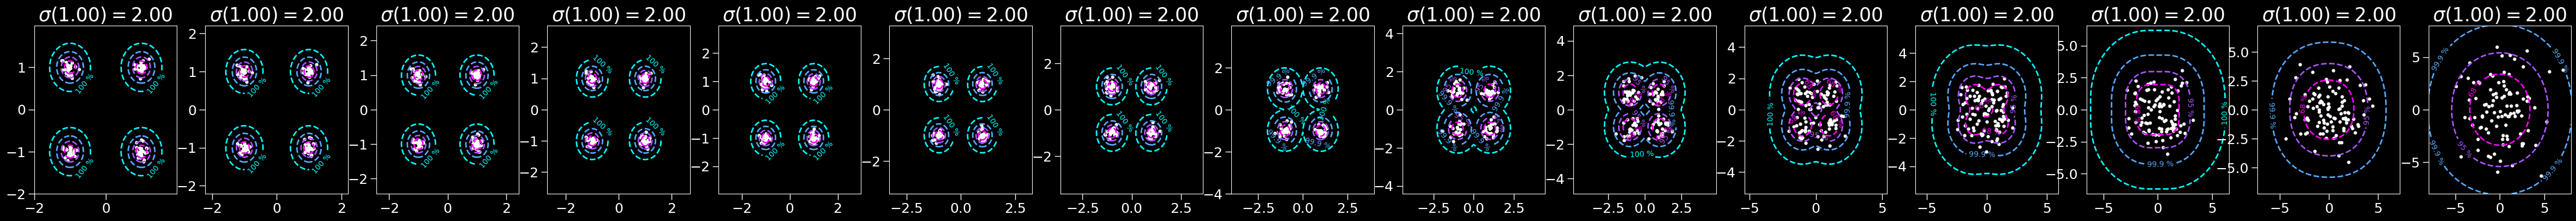

In [33]:
# initial condition
x = dist.sample([100])

len_frames = 15
ts, dt = np.linspace(0, 1, len_frames, retstep=True)
_max = np.logspace(np.log10(2), np.log10(8), len_frames)
fig, axs = plt.subplots(1, len_frames, figsize=(4*len_frames, 4))
for i in range(len_frames):
    x = forward_euler_maruyama(x, torch.ones(x.shape[0]).to(DEVICE) * ts[i], dt)
    axs[i].plot(x.numpy()[:, 0], x.numpy()[:, 1], "w.", markersize=7)
    # for reference, draw the contours of the marginal in time like before
    density_contours(lambda x: density(x, torch.tensor(ts[i])), xmin=-_max[i], xmax=_max[i], ymin=-_max[i], ymax=_max[i], confidence_intervals=[0.68, 0.95, 0.999, 0.9999999], ax=axs[i])
    axs[i].set_title(f"$\sigma(%.2f) = %.2f$" % (t, sigma(t)))

## Anderson reverse-time formula

An amazing thing about these SDE is that we can reverse their dynamic in time and recover samples from the original distribution! The trajectories themselves are not reversible (because of the nosie added), but the (time-) marginal density of the diffusion, $p_t(x)$, follows a PDE (the Fokker-Planck equation) which is reversible in time.

The explicit reverse-time formula for the SDE considered above is
$$
  d \mathbf{x} = -g(t)^2\nabla_{\mathbf{x}} \log p_t(\mathbf{x}) dt + g(t) d \bar{\mathbf{w}}
$$
where $\bar{\mathbf{w}}$ is a reverse-time brownian motion. In practice, it can
be approximated by
$$
  \bar{\mathbf{w}} \approx \mathbf{z}\sqrt{- dt}
$$
where the minus sign in the square root is there to account for the fact that $dt < 0$.

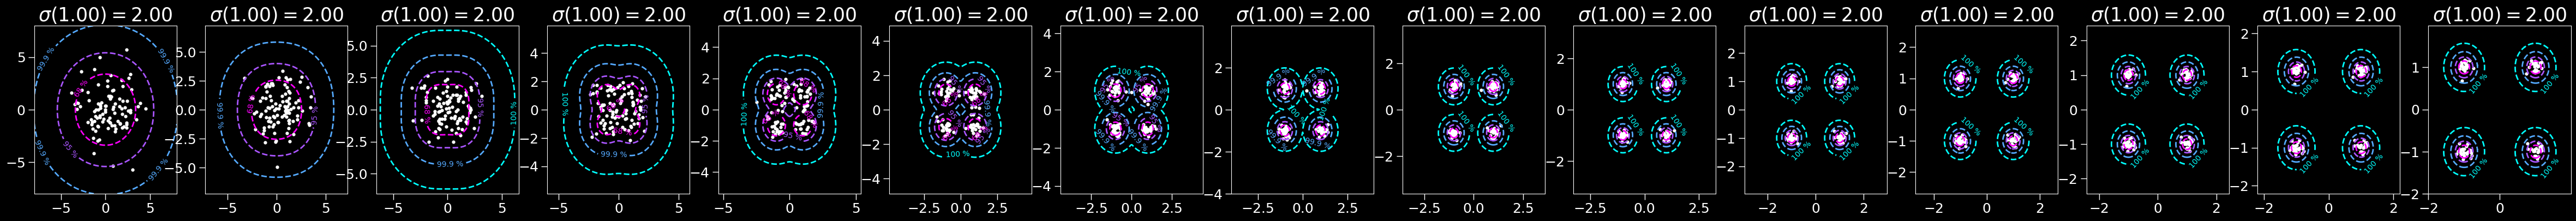

In [34]:
def reversed_euler_maruyama(x, t, dt, score_fn):
    z = torch.randn_like(x)
    return x - g(t).view(-1, 1)**2 * score_fn(x, t) * dt +  g(t).view(-1, 1) * z * (-dt)**(1/2)

# initial condition is now high temperature
x = torch.randn([100, 2]) * sigma(1.)

len_frames = 15
ts, dt = np.linspace(1, 0, len_frames, retstep=True)
_max = np.logspace(np.log10(2), np.log10(8), len_frames)[::-1]
fig, axs = plt.subplots(1, len_frames, figsize=(4*len_frames, 4))
with torch.no_grad():
  for i in range(len_frames):
      x = reversed_euler_maruyama(x, torch.ones(x.shape[0]).to(DEVICE) * ts[i], dt, score_fn=model) # You can use true_score or model here
      axs[i].plot(x.numpy()[:, 0], x.numpy()[:, 1], "w.", markersize=7)
      density_contours(lambda x: density(x, torch.tensor(ts[i])), xmin=-_max[i], xmax=_max[i], ymin=-_max[i], ymax=_max[i], confidence_intervals=[0.68, 0.95, 0.999, 0.9999999], ax=axs[i])
      axs[i].set_title(f"$\sigma(%.2f) = %.2f$" % (t, sigma(t)))

# Score matching with samples

When we only have access to samples, there is a few things we can do. One of the ways we could compute the loss would be to use sliced score matching (Hyvarïnen 2005) or a variant of denoising score matching described by Vincent 2011. We will cover the latter since it is the most used.

The first trick is to realize that you can always define a sample distribution as a sum of Dirac delta, a sort of empirical approximation of the true underlying distribution
$$
  \tilde{p}(\mathbf{x}) = \frac{1}{N}\sum_{i=1}^N \delta(\mathbf{x} - \mathbf{x}_i)
$$

The convolution with noise is then trivial
$$
  \tilde{p}_t(\mathbf{x}) = \frac{1}{N}\sum_{i=1}^N \mathcal{N}(\mathbf{x}_i, \sigma_t^2 \mathbb{1}_n)
$$

There is a cool trick, discovered by Pascal Vincent (2011), which allows us to construct an equivalence between the score matching loss we have been using
$$
  \mathcal{L}_\theta = \mathbb{E}_{\mathbf{x}_0 \sim p(\mathbf{x})} \mathbb{E}_{t \sim \mathcal{U}(0, 1)} \mathbb{E}_{\mathcal{z} \sim \mathcal{N}(0, 1)} \big[\lambda(t) \lVert \mathbf{s}_\theta(\tilde{\mathbf{x}}_t, t) - \nabla_{\tilde{\mathbf{x}}} p_t(\tilde{\mathbf{x}})\rVert^2 \big]
$$
where $\tilde{\mathbf{x}}_t = \mathbf{x}_0 + \sigma_t \mathbf{z}$,
and what is called the denoising score matching loss
$$
  \mathcal{L}_\theta = \mathbb{E}_{\mathbf{x}_0 \sim p(\mathbf{x})} \mathbb{E}_{t \sim \mathcal{U}(0, 1)} \mathbb{E}_{\mathcal{z} \sim \mathcal{N}(0, 1)} \big[\lambda(t) \lVert \mathbf{s}_\theta(\tilde{\mathbf{x}}_t, t) - \nabla_{\tilde{\mathbf{x}}} p_t(\tilde{\mathbf{x}} \mid \mathbf{x}_0)\rVert^2 \big]
$$

With our empirical distribution, we can trivially estimate $\nabla_{\mathbf{x}} p_t(\tilde{\mathbf{x}} \mid \mathbf{x}_0)$
$$
  \nabla_{\tilde{\mathbf{x}}} p_t(\tilde{\mathbf{x}} \mid \mathbf{x}_0) = -\frac{\mathbf{z}}{\sigma_t}
$$
It's a good exercise to figure this out by yourself. Note that the conditioning on $\mathbf{x}_0$ collapses the sum of Dirac to only one Dirac, the one centered on $\mathbf{x}_0$.

100%|██████████| 50000/50000 [02:32<00:00, 327.78it/s]


Text(0.5, 0, 'Iteration')

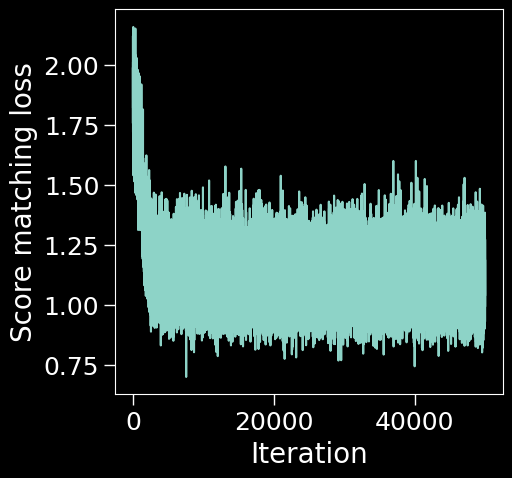

In [41]:
# Finally, here is how you would construct the training algorithm
model2 = Model()
iterations = 50000
batch_size = 256
learning_rate = 1e-3
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
losses = []
for _ in tqdm(range(iterations)):
    optimizer.zero_grad()
    x = dist.sample([batch_size])
    t = torch.rand(batch_size).to(DEVICE)
    z = torch.randn_like(x)
    lambda_t = (sigma(t)**2).view(-1, 1)
    loss = torch.sum(lambda_t * (model2(x + sigma(t)[:, None] * z, t) + z / sigma(t)[:, None])**2) / batch_size
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.ylabel("Score matching loss")
plt.xlabel("Iteration")

Text(0, 0.5, 'True score')

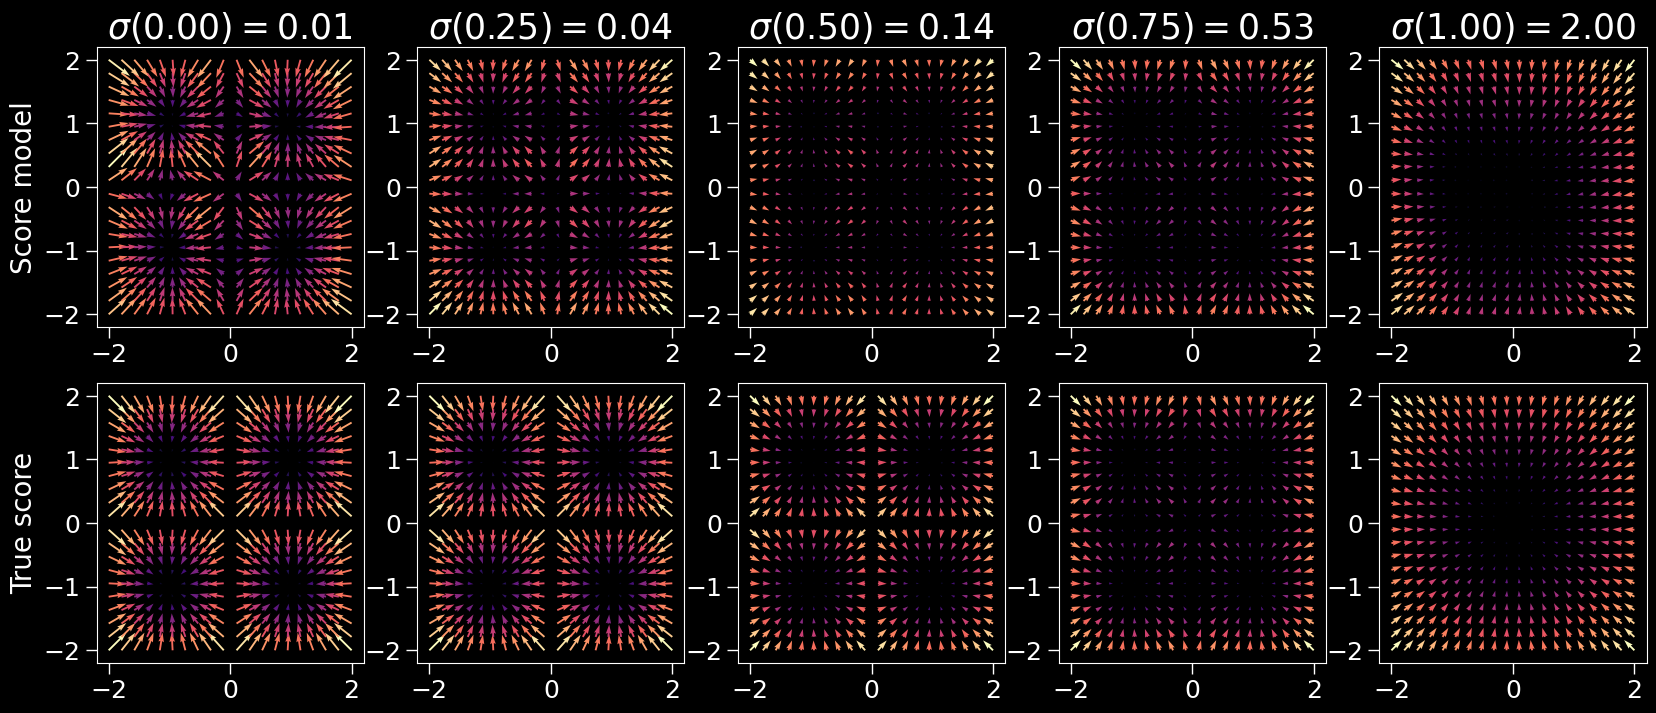

In [42]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))


ts = [0, 0.25, 0.5, 0.75, 1]
scales = [1.5e3, 1.5e3, 9e2, 9e1, 1e1]
for i, t in enumerate(ts):
    ax1 = vector_field(lambda x: model2(x, torch.ones(20**2).to(DEVICE)*t), xmin=-2, xmax=2, ymin=-2, ymax=2, n=20, dx=0.05, scale=scales[i], ax=axs[0, i])
    ax2 = vector_field(lambda x: true_score(x, torch.ones(20**2).to(DEVICE)*t), xmin=-2, xmax=2, ymin=-2, ymax=2, n=20, dx=0.05, scale=scales[i], ax=axs[1, i])
    ax1.set_title(f"$\sigma(%.2f) = %.2f$" % (t, sigma(t)))

axs[0, 0].set_ylabel(r"Score model")
axs[1, 0].set_ylabel(r"True score")

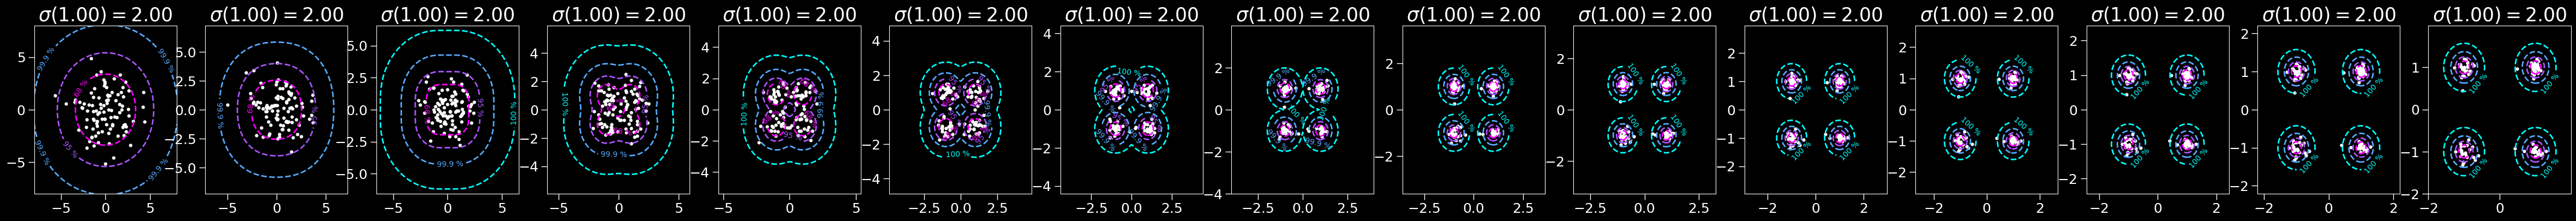

In [40]:
# You can now sample from this neural network to recover the distribution of interest
x = torch.randn([100, 2]) * sigma(1.)

len_frames = 15 # note that increasing this number makes diffusion more stable, improves sampling accuracy
ts, dt = np.linspace(1, 0, len_frames, retstep=True)
_max = np.logspace(np.log10(2), np.log10(8), len_frames)[::-1]
fig, axs = plt.subplots(1, len_frames, figsize=(4*len_frames, 4))
with torch.no_grad():
  for i in range(len_frames):
      x = reversed_euler_maruyama(x, torch.ones(x.shape[0]).to(DEVICE) * ts[i], dt, score_fn=model2) # <- Use the score model in the diffusion
      axs[i].plot(x.numpy()[:, 0], x.numpy()[:, 1], "w.", markersize=7)
      density_contours(lambda x: density(x, torch.tensor(ts[i])), xmin=-_max[i], xmax=_max[i], ymin=-_max[i], ymax=_max[i], confidence_intervals=[0.68, 0.95, 0.999, 0.9999999], ax=axs[i])
      axs[i].set_title(f"$\sigma(%.2f) = %.2f$" % (t, sigma(t)))